/opt/anaconda3/lib/python3.12/site-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


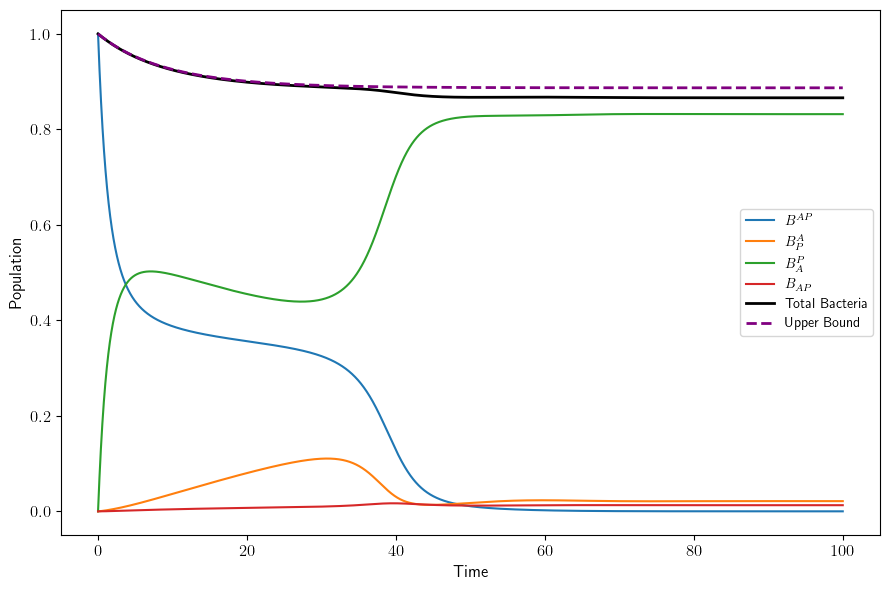

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

plt.rcParams["text.usetex"] = True

# Parameters
rho1 = 0.1
rho2 = 0.1
rho3 = 0.1
rho4 = 0.1

alpha1 = 1e-2
alpha2 = 0.1
alpha3 = 1e-2
delta2 = 1e-3

phi1 = 0.4
phi2 = 0.8
phi3 = 0.1
gamma = 1e-3
eta = 0.4

CC = 0.887  # Carrying capacity

A = 0.1  # Antibiotic concentration
burstsize = 180

# Full system of ODEs
def system(t, y):
    B1, B2, B3, B4, P = y
    BA = B1 + B2 + B3 + B4
    dB1 = rho1 * B1 * (1 - BA / CC) - alpha1 * A * B1 - phi1 * P * B1
    dB2 = rho2 * B2 * (1 - BA / CC) + alpha1 * A * B1 + alpha2*A*B3 -(phi2+phi3)*P * B2 - delta2 * (A / (1 + A)) *B2
    dB3 = rho3 * B3 * (1 - BA / CC)  + phi1 * P * B1 - (alpha2+alpha3) * A * B3+phi2*P*B2 - gamma*(P/(1+P))*B3
    dB4 = rho4 * B4 * (1 - BA / CC) + alpha3 * A * B3 + phi3 * P * B2 - eta * ((P + A) / (1 + P + A)) * B4
    dP  = burstsize * (gamma * (P / (1 + P)) * B3 + eta * (P / (1 + P)) * B4) - (phi1*B1 + (phi2+phi3)*B3)*P
    return np.array([dB1, dB2, dB3, dB4, dP])

# Time settings
t_final = 100
t_eval = np.linspace(0, t_final, 10000)
y0 = [1.0, 0.0, 0.0, 0.0, 1]

# Solve the full system
sol = solve_ivp(system, [0, t_final], y0, t_eval=t_eval, method='RK45', rtol=1e-14, atol=1e-14)
t = sol.t
B1, B2, B3, B4, P = sol.y
B_total = B1 + B2 + B3 + B4

def logistic_bound(t, B, rho):
    return rho * B * (1 - B / CC)

# Initial conditions for each B_i
y0_bounds = y0[:4]
rhos = [rho1, rho3, rho2, rho4]

# Solve logistic bounds for each B_i
bounds = []
for i in range(4):
    sol_i = solve_ivp(logistic_bound, [0, t_final], [y0_bounds[i]], t_eval=t_eval, args=(rhos[i],), rtol=1e-10, atol=1e-10)
    bounds.append(sol_i.y[0])

# Sum of individual logistic bounds
B_total_bound = np.sum(bounds, axis=0)



# Plot all results
plt.figure(figsize=(9, 6))
plt.plot(t, B1, label=r'$B^{AP}$')
plt.plot(t, B2, label=r'$B^A_P$')
plt.plot(t, B3, label=r'$B^P_A$')
plt.plot(t, B4, label=r'$B_{AP}$')



plt.plot(t, B_total, label='Total Bacteria', linewidth=2, color='black')
plt.plot(t, B_total_bound, '--', label='Upper Bound', color='purple', linewidth=2)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Population', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center right')


plt.tight_layout()
plt.savefig('total_pop_hist_2.pdf')
#plt.ylim(0,0.75)
plt.show()
